Linear Regression model to estimate earthquake latitude given depth, magnitude, and other related features.

By Aanchel

In [923]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [924]:
# import data
data_open = open('database.csv')
data = pd.read_csv(data_open, delimiter=',')
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [925]:
# clean data
cols = ['Date', 'Time', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID', 'Source',
        'Location Source', 'Magnitude Source', 'Status', 'Azimuthal Gap', 'Magnitude Error', 
        'Depth Error', 'Magnitude Seismic Stations']
data = data.drop(cols, axis=1)
data = data.drop(data.index[data['Type'] != 'Earthquake'])
data = data.drop(['Type'], axis=1)
data = data.drop(data.index[data['Depth'] < 0])
data = data.drop(data.index[data['Depth'] > 30])
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3868 entries, 489 to 23408
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                3868 non-null   float64
 1   Longitude               3868 non-null   float64
 2   Depth                   3868 non-null   float64
 3   Depth Seismic Stations  3868 non-null   float64
 4   Magnitude               3868 non-null   float64
 5   Magnitude Type          3868 non-null   object 
dtypes: float64(5), object(1)
memory usage: 211.5+ KB


,Latitude,Longitude,Depth,Depth Seismic Stations,Magnitude
count,3868.000000,3868.000000,3868.000000,3868.000000,3868.000000
mean,1.051775,32.626899,13.824810,260.060755,5.890189
std,32.130665,119.963068,6.566981,161.834592,0.423501
min,-77.080000,-179.971000,0.000000,0.000000,5.500000
25%,-19.993250,-84.311500,10.000000,132.000000,5.600000
50%,-1.078500,91.781500,10.000000,238.000000,5.800000
75%,29.620500,141.573500,18.000000,365.000000,6.100000
max,86.005000,179.911000,30.000000,885.000000,9.100000


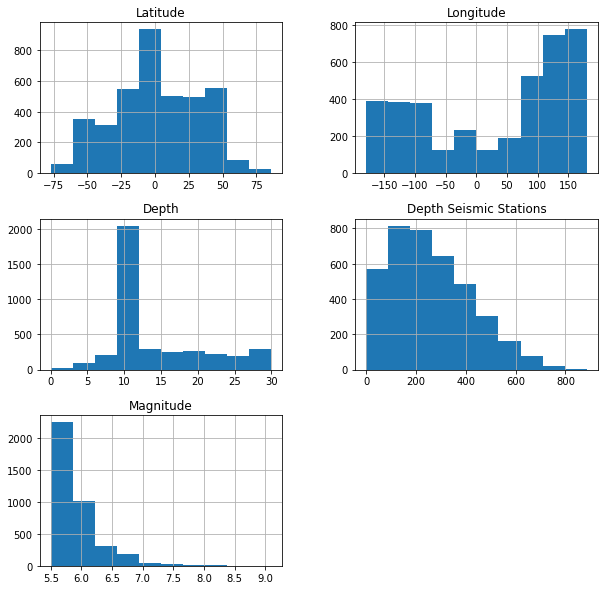

In [926]:
# View data
data.hist(figsize=(10,10))
data.describe()

In [927]:
# clean up outliers
data['DepthZ'] = (data['Depth'] - data['Depth'].mean()) / data['Depth'].std()
data = data.drop(data.index[(data['DepthZ'] > 4) | (data['DepthZ'] < -4)])
data = data.drop(columns=['DepthZ'])

data['LatZ'] = (data['Latitude'] - data['Latitude'].mean()) / data['Latitude'].std()
data = data.drop(data.index[(data['LatZ'] > 4) | (data['LatZ'] < -4)])
data = data.drop(columns=['LatZ'])

data['LonZ'] = (data['Longitude'] - data['Longitude'].mean()) / data['Longitude'].std()
data = data.drop(data.index[(data['LonZ'] > 4) | (data['LonZ'] < -4)])
data = data.drop(columns=['LonZ'])

data['MagZ'] = (data['Magnitude'] - data['Magnitude'].mean()) / data['Magnitude'].std()
data = data.drop(data.index[(data['MagZ'] > 4) | (data['MagZ'] < -4)])
data = data.drop(columns=['MagZ'])

data['Depth Seismic StationsZ'] = (data['Depth Seismic Stations'] - data['Depth Seismic Stations'].mean()) / data['Depth Seismic Stations'].std()
data = data.drop(data.index[(data['Depth Seismic StationsZ'] > 4) | (data['Depth Seismic StationsZ'] < -4)])
data = data.drop(columns=['Depth Seismic StationsZ'])

data.describe()

,Latitude,Longitude,Depth,Depth Seismic Stations,Magnitude
count,3834.000000,3834.000000,3834.000000,3834.000000,3834.000000
mean,0.994499,32.267585,13.782672,257.894888,5.871661
std,32.132539,120.025764,6.545618,160.358243,0.374571
min,-77.080000,-179.971000,0.000000,0.000000,5.500000
25%,-20.198250,-84.793500,10.000000,131.000000,5.600000
50%,-1.118500,91.711500,10.000000,236.000000,5.800000
75%,29.367500,141.552000,17.675000,362.750000,6.000000
max,86.005000,179.911000,30.000000,885.000000,7.500000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 890 to 23408
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                3630 non-null   float64
 1   Longitude               3630 non-null   float64
 2   Depth                   3630 non-null   float64
 3   Depth Seismic Stations  3630 non-null   float64
 4   Magnitude               3630 non-null   float64
 5   Type_MB                 3630 non-null   uint8  
 6   Type_MD                 3630 non-null   uint8  
 7   Type_MH                 3630 non-null   uint8  
 8   Type_ML                 3630 non-null   uint8  
 9   Type_MS                 3630 non-null   uint8  
 10  Type_MW                 3630 non-null   uint8  
 11  Type_MWB                3630 non-null   uint8  
 12  Type_MWC                3630 non-null   uint8  
 13  Type_MWR                3630 non-null   uint8  
 14  Type_MWW                3630 non-null

array([[<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'Depth'}>,
        <AxesSubplot:title={'center':'Depth Seismic Stations'}>],
       [<AxesSubplot:title={'center':'Magnitude'}>,
        <AxesSubplot:title={'center':'Type_MB'}>,
        <AxesSubplot:title={'center':'Type_MD'}>,
        <AxesSubplot:title={'center':'Type_MH'}>],
       [<AxesSubplot:title={'center':'Type_ML'}>,
        <AxesSubplot:title={'center':'Type_MS'}>,
        <AxesSubplot:title={'center':'Type_MW'}>,
        <AxesSubplot:title={'center':'Type_MWB'}>],
       [<AxesSubplot:title={'center':'Type_MWC'}>,
        <AxesSubplot:title={'center':'Type_MWR'}>,
        <AxesSubplot:title={'center':'Type_MWW'}>, <AxesSubplot:>]],
      dtype=object)

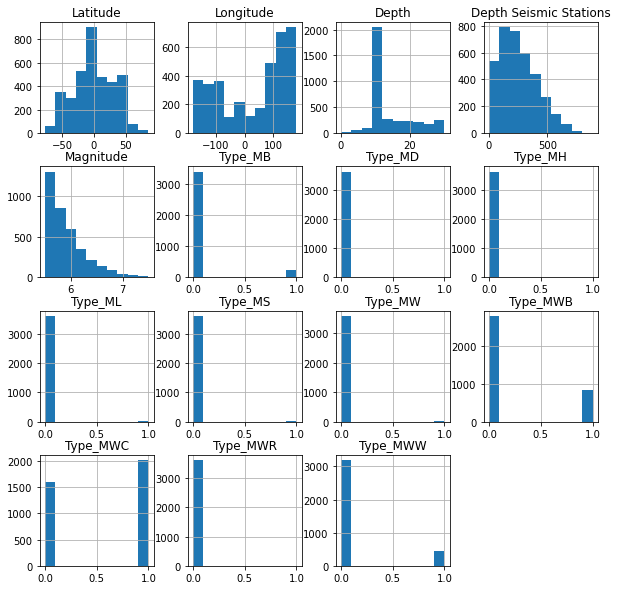

In [928]:
# one hot encode Magnitude Type
data = pd.concat([data, pd.get_dummies(data['Magnitude Type'], prefix='Type')],axis=1)
data = data.drop(columns=['Magnitude Type'])

# even out data for Depth < 10
data = data.drop(data[data['Depth'] < 10].sample(frac=.5).index)

data.info()
data.hist(figsize=(10,10))

In [929]:
# split data into train and test set
data_copy = data
y = data['Latitude']
X = data.drop(columns=['Latitude'])

y = y.values
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=144)

Training Accuracy:  0.45760206488402977
Test Accuracy:  0.47690540394746417
MSE 572.9794895618942
R2 0.47690540394746417


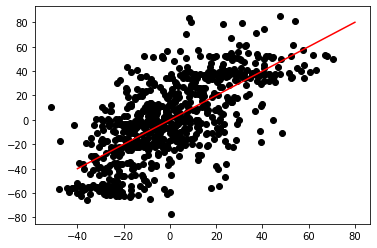

In [930]:
# fit regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# generate predictions
y_predict = regressor.predict(X_test)

# graph comparison of train and test
plt.scatter(y_predict, y_test, color='black')
x = np.linspace(-40, 80)
plt.plot(x, x, color='red')

# get accuracies
print("Training Accuracy: ", regressor.score(X_train, y_train))
print("Test Accuracy: ", regressor.score(X_test, y_test))

# get metrics
print('MSE', mean_squared_error(y_test, y_predict))
print('R2', r2_score(y_test, y_predict))

Training Accuracy:  0.4965218587406858
Test Accuracy:  0.5097721765017721
MSE 536.9783786656484
R2 0.5097721765017721


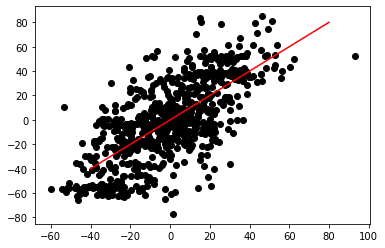

In [931]:
# polynomial regression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train_poly, y_train)

y_predict_poly = regressor.predict(X_test_poly)

# graph comparison of train and test
plt.scatter(y_predict_poly, y_test, color='black')
x = np.linspace(-40, 80)
plt.plot(x, x, color='red')

# get accuracies
print("Training Accuracy: ", regressor.score(X_train_poly, y_train))
print("Test Accuracy: ", regressor.score(X_test_poly, y_test))

# get metrics
print('MSE', mean_squared_error(y_test, y_predict_poly))
print('R2', r2_score(y_test, y_predict_poly))